In [1]:
import os
import warnings
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from urllib.parse import urlparse
import mlflow
import mlflow.sklearn

tunnel = pd.read_csv('./tunnel.csv', parse_dates=['Day'])
tunnel = tunnel.set_index('Day')
print(tunnel.head())

            NumVehicles
Day                    
2003-11-01       103536
2003-11-02        92051
2003-11-03       100795
2003-11-04       102352
2003-11-05       106569


In [2]:
tunnel['Time'] = np.arange(len(tunnel.index))
tunnel['lag'] = tunnel['NumVehicles'].shift(1)
tunnel.dropna(inplace = True)
print(tunnel.head())

            NumVehicles  Time       lag
Day                                    
2003-11-02        92051     1  103536.0
2003-11-03       100795     2   92051.0
2003-11-04       102352     3  100795.0
2003-11-05       106569     4  102352.0
2003-11-06       106284     5  106569.0


In [3]:
plot_params = dict(
    color = '0.75',
    style = '.-',
    markeredgecolor = '0.25',
    markerfacecolor='0.25',
    legend = False
)

In [4]:

def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

Linear Regression model:
  RMSE: 9901.394812392922
  MAE: 8557.313343378291
  R2: 0.2580965738151094


TypeError: Unsupported figure object type: '<class 'matplotlib.axes._subplots.AxesSubplot'>'

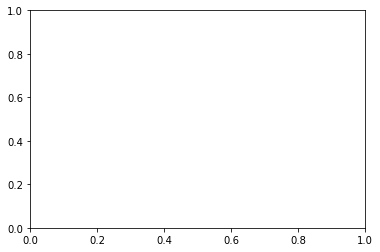

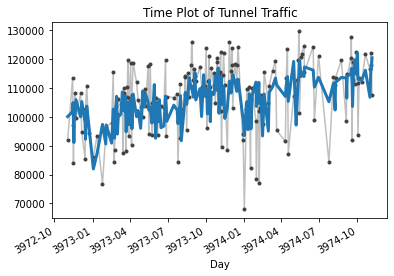

In [26]:
warnings.filterwarnings("ignore")
np.random.seed(40)
# Read the wine-quality csv file from the URL


# Split the data into training and test sets. (0.75, 0.25) split.
train, test = train_test_split(tunnel)

# The predicted column is "quality" which is a scalar from [3, 9]
train_x = train.drop(["NumVehicles"], axis=1)
test_x = test.drop(["NumVehicles"], axis=1)
train_y = train[["NumVehicles"]]
test_y = test[["NumVehicles"]]

with mlflow.start_run():
    model = LinearRegression()
    model.fit(train_x, train_y)
 
    predicted_qualities = model.predict(test_x)
    
    y_pred = pd.Series(predicted_qualities.flatten(), index = test_x.index)
    
    (rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)

    print("Linear Regression model:")
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)

    fig, ax = plt.subplots()
    ax = test_y.plot(**plot_params)
    ax=y_pred.plot(ax=ax, linewidth = 3)
    ax.set_title('Time Plot of Tunnel Traffic')

    tags = {'purpose' : 'education',
            'problem' : 'time-series'}

    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.log_figure(ax, "ts-regress.png")
    mlflow.set_tags(tags)

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        # Model registry does not work with file store
    if tracking_url_type_store != "file":

            # Register the model
            # There are other ways to use the Model Registry, which depends on the use case,
            # please refer to the doc for more information:
            # https://mlflow.org/docs/latest/model-registry.html#api-workflow
        mlflow.sklearn.log_model(model, "model", registered_model_name="LinRegTunnelModel")
    else:
        mlflow.sklearn.log_model(model, "model")